## Models & Forecastiong

In [1]:
import numpy as np  
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  
# import plotly.plotly as py # visualization library
from plotly.offline import init_notebook_mode, iplot  
init_notebook_mode(connected=True) 
import plotly.graph_objs as go 
import os
import warnings        
warnings.filterwarnings("ignore") 

In [2]:
#read data
path = "/Users/reign/Downloads/store-sales-time-series-forecasting/"

oil = pd.read_csv(path + 'oil.csv')
trans = pd.read_csv(path + 'transactions.csv')
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

변수설명

oil
- date: 날짜
- dcoilwtico: daily price (변수 설명에 따르면, 이 데이터의 배경인 콜롬비아의 경제는 유가에 크게 의존하고 있다고 한다.)

train
- date: 날짜
- store_nbr: identifies the store at which the products are sold.
- family: 상품군
- sales:: 총판매량 (target)
- onpromption: gives the total number of items in a product family that were being promoted at a store at a given date. 

test
- date: 날짜(train의 마지막 날짜로부터 15일 뒤)
- 나머지, train과 동일

trans
- date: 날짜
- store_nbr: 상점 번호
- transaction: 거래 수

In [3]:
ts1 = train.copy()
ts2 = oil.copy()
#시계열화
ts1['date'] = pd.to_datetime(ts1['date']) #시계열 입히기
ts1['day_of_week'] = ts1['date'].dt.dayofweek
ts1['month'] = ts1['date'].dt.month
ts1['year'] = ts1['date'].dt.year

In [42]:
#Grouper #시계열이 중복된 것이 많을 때 유용하다. or 윈도우가 정해져 있을 때
def group(df, key, freq, col):
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index() #date를 인덱스가 아닌 컬럼으로 지정
    return df_grouped
    
ts1_d = group(ts1, 'date', 'd', 'sales')
#ts1_w = group(ts1, 'date', 'w', 'sales')
#ts1_m = group(ts1, 'date', 'm', 'sales')
#ts1_y = group(ts1, 'date', 'y', 'sales')

In [30]:
#ts1_w = ts1_w.set_index('date')
#ts1_d = ts1_d.set_index('date')
#ts_diff = ts1_d - ts1_w
#ts_diff = ts_diff.dropna()

In [43]:
ts1_d = ts1_d.set_index('date')
ts1_d_lag = ts1_d.shift(30)
ts_diff = ts1_d - ts1_d_lag
ts_diff = ts_diff.dropna()

<AxesSubplot:xlabel='date', ylabel='mean'>

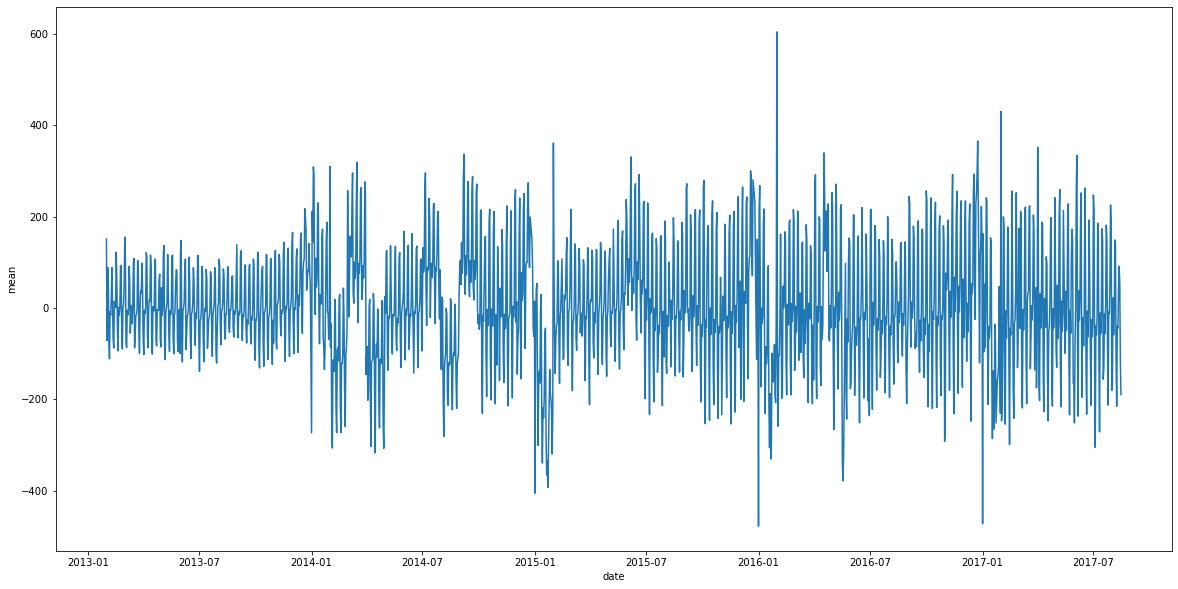

In [44]:
plt.figure(figsize=(20,10))
sns.lineplot(ts_diff.index,ts_diff['mean']) #check the spike!

## 가변수 회귀
- 모든 시점의 변동을 동일하게 처리
- 더미변수 구성시 홀리데이나 특정 스파이크의 효과 파악 가능

In [56]:
#Regression
def add_time(df, key, freq, col):
    df_grouped = group(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index)) #인덱스 길이
    #column_time = df_grouped.pop('time') #pop 열 추출
    #df_grouped.insert(1, 'time', column_time) #insert 열 삽입
    return df_grouped

In [62]:
ts1_reg = add_time(ts1, 'date', 'd', 'sales')
ts1_reg

,date,mean,time
0,2013-01-01,1.409438,0
1,2013-01-02,278.390807,1
2,2013-01-03,202.840197,2
3,2013-01-04,198.911154,3
4,2013-01-05,267.873244,4
...,...,...,...
1683,2017-08-11,463.733851,1683
1684,2017-08-12,444.798280,1684
1685,2017-08-13,485.768618,1685
1686,2017-08-14,427.004717,1686


In [79]:
ts1_reg.dropna(inplace=True)
#len(ts1_reg['time'])
len(ts1_reg['mean'])

1684

In [82]:
from sklearn.linear_model import LinearRegression

#2차원 인풋을 넣어줄 것.
X = ts1_reg.loc[:,['time']]
y = ts1_reg.loc[:,['mean']]

regmodel = LinearRegression()
regmodel.fit(X, y)

y_pred = pd.Series(regmodel.predict(X), index=X.index)

LinearRegression()

## ARIMA 
정상성 검정 ADF Test
- 귀무가설: 시계열 자료가 정상 시계열이 아니다.
- 대립가설: 시계열 자료가 정상 시계열다.

In [45]:
from statsmodels.tsa.stattools import adfuller

# Check adfuller
def check_adfuller(ts):
    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

In [46]:
ts1_d=ts1_d.dropna()
check_adfuller(ts1_d) #귀무가설 기각x

Test statistic:  -2.616195748604867
p-value:  0.08969592175787278
Critical Values: {'1%': -3.4342930672797065, '5%': -2.8632816397229064, '10%': -2.567697207194407}
Test statistic:  -1.5903747027604556
p-value:  0.48842681062681403
Critical Values: {'1%': -3.458854867412691, '5%': -2.8740800599399323, '10%': -2.573453223097503}


In [47]:
#but check this
check_adfuller(ts_diff) #reject H0 when the lag is 30

Test statistic:  -9.30487505117156
p-value:  1.0875616653298752e-15
Critical Values: {'1%': -3.4343830457666806, '5%': -2.8633213561112156, '10%': -2.5677183557141645}


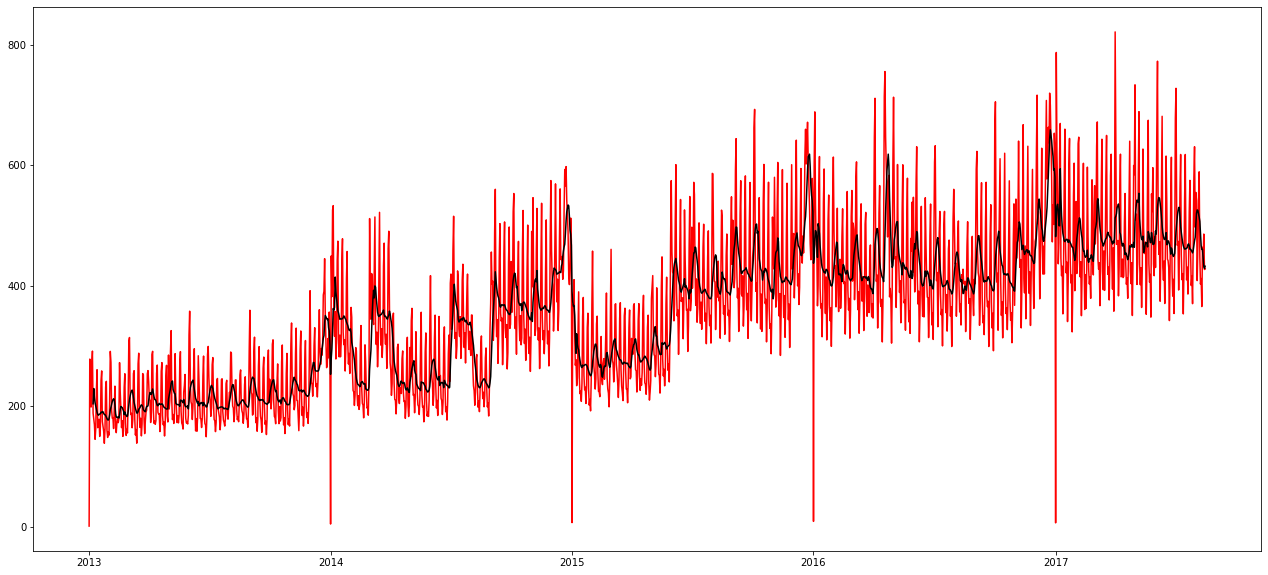

In [49]:
rolmean = ts1_d.rolling(7).mean()

plt.figure(figsize=(22,10))   
plt.plot(ts1_d, color='red',label='Original')
plt.plot(rolmean, color='black', label='Rolling Mean')

plt.show()

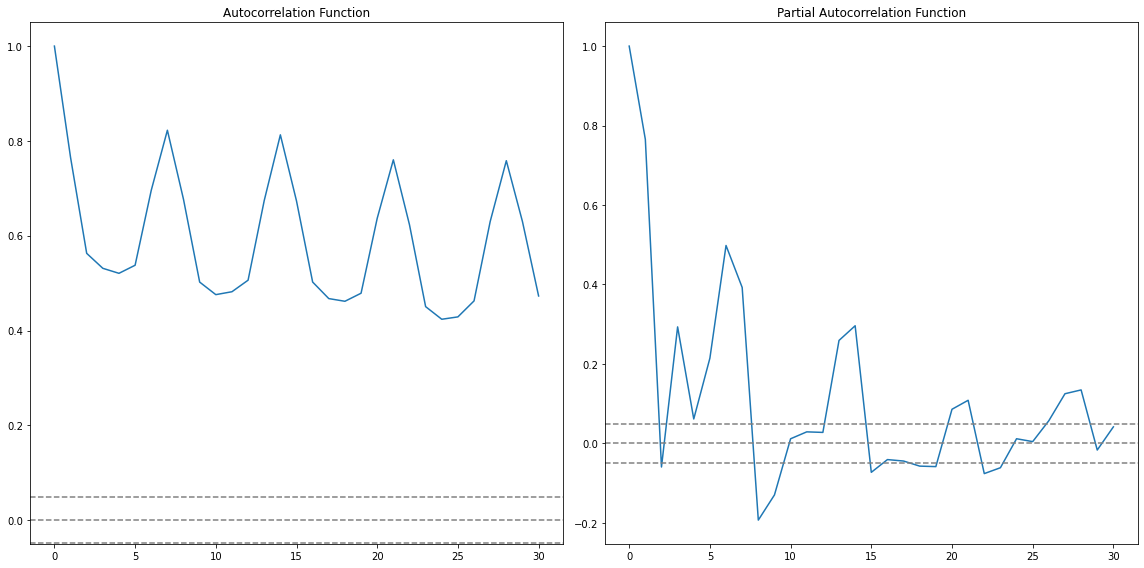

In [67]:
# ACF and PACF 
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts1_d, nlags=30)
lag_pacf = pacf(ts1_d, nlags=30, method='ols')
# ACF
plt.figure(figsize=(16,8))

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
#Regression
def add_time(df, key, freq, col):
    """ ADD COLUMN 'TIME' TO DF """
    df_grouped = grouped(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index)) #인덱스 길이
    column_time = df_grouped.pop('time') #pop 열 추출
    df_grouped.insert(1, 'time', column_time) #insert 열 삽입
    return df_grouped